In [2]:
import os

base_dir = r"F:\UOJE\Semester 7\Digital Image Processing\Project\data\final"
valid_exts = ('.png', '.jpg', '.jpeg', '.bmp', '.tif', '.tiff', '.webp')

for folder in os.listdir(base_dir):
    folder_path = os.path.join(base_dir, folder)
    if os.path.isdir(folder_path):
        # Count only valid image files
        count = sum(1 for f in os.listdir(folder_path) if f.lower().endswith(valid_exts))
        print(f"{folder}: {count} images")


battery: 1989 images
biological: 1989 images
brown-glass: 1989 images
cardboard: 1989 images
clothes: 1989 images
green-glass: 1989 images
metal: 1989 images
paper: 1989 images
plastic: 1989 images
shoes: 1989 images
trash: 1989 images
white-glass: 1989 images


In [3]:
# ===================== K-FOLD CV (MobileNetV2, no tuning) =====================
import os, cv2, numpy as np, tensorflow as tf
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input, MobileNetV2
from tensorflow.keras import layers, models, callbacks


In [4]:
# -------------------- CONFIG --------------------
IMG_SIZE      = 224
DATASET_PATH  = r"F:\UOJE\Semester 7\Digital Image Processing\Project\data\final"
VALID_EXTS    = (".png", ".jpg", ".jpeg", ".bmp", ".tif", ".tiff", ".webp")
SEED          = 42
N_SPLITS      = 5           # K folds
BATCH_SIZE    = 32
EPOCHS        = 20
FINE_TUNE_AT  = None        # e.g., 100 to unfreeze last 100 layers for fine-tuning

# Reproducibility
np.random.seed(SEED)
tf.random.set_seed(SEED)

# Optional: GPU memory growth
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for g in gpus: tf.config.experimental.set_memory_growth(g, True)
    except Exception:
        pass

# -------------------- HELPERS --------------------
def imread_unicode(path, flags=cv2.IMREAD_COLOR):
    data = np.fromfile(path, dtype=np.uint8)
    if data.size == 0: return None
    return cv2.imdecode(data, flags)

def enhance_image(img):
    if img is None: return None
    ycrcb = cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    y, cr, cb = cv2.split(ycrcb)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    y = clahe.apply(y)
    return cv2.cvtColor(cv2.merge([y, cr, cb]), cv2.COLOR_YCrCb2BGR)

def build_model(num_classes, img_size=224, fine_tune_at=FINE_TUNE_AT, dropout=0.2, lr=1e-3):
    base = MobileNetV2(
        input_shape=(224, 224, 3),  # Explicitly set input shape to (224, 224, 3)
        include_top=False,
        weights="imagenet"
    )
    base.trainable = False
    if fine_tune_at is not None:
        for layer in base.layers[-fine_tune_at:]:
            layer.trainable = True

    inputs = layers.Input(shape=(224, 224, 3))  # Match input shape explicitly
    x = base(inputs, training=False)  # keep BN in inference mode while frozen
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(dropout)(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)
    model = models.Model(inputs, outputs)

    model.compile(
        optimizer=tf.keras.optimizers.Adam(lr),
        loss="categorical_crossentropy",
        metrics=[
        "accuracy",
        tf.keras.metrics.Precision(name="precision"),
        tf.keras.metrics.Recall(name="recall"),
        tf.keras.metrics.AUC(name="auc"),
        tf.keras.metrics.TopKCategoricalAccuracy(k=3, name="top_3_accuracy")
    ]
    )
    return model

def preprocess_image(file_path):
    """Load and preprocess an image from a file path."""
    img = imread_unicode(file_path)
    if img is None:
        raise ValueError(f"Could not read image: {file_path}")
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))  # Resize to (IMG_SIZE, IMG_SIZE)
    img = img.astype(np.float32) / 255.0  # Convert to float32 and normalize to [0, 1]
    return img

def make_ds(X, y_onehot, training=True, batch_size=BATCH_SIZE):
    """Create a TensorFlow dataset with preprocessing."""
    def load_and_preprocess(file_path, label):
        img = tf.numpy_function(preprocess_image, [file_path], tf.float32)
        img.set_shape((IMG_SIZE, IMG_SIZE, 3))  # Set static shape
        return img, label

    ds = tf.data.Dataset.from_tensor_slices((X, y_onehot))
    ds = ds.map(load_and_preprocess, num_parallel_calls=tf.data.AUTOTUNE)
    if training:
        ds = ds.shuffle(8192, seed=SEED, reshuffle_each_iteration=True)
    ds = ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return ds


In [5]:
# -------------------- LOAD DATA --------------------
import os
from sklearn.preprocessing import LabelEncoder

# Define constants
IMG_SIZE = 224  # Image size for MobileNetV2
VALID_EXTS = (".png", ".jpg", ".jpeg", ".bmp", ".tif", ".tiff", ".webp")

# Load dataset paths and labels
X, y = [], []
for folder in os.listdir(DATASET_PATH):
    folder_path = os.path.join(DATASET_PATH, folder)
    if os.path.isdir(folder_path):
        for file in os.listdir(folder_path):
            if file.lower().endswith(VALID_EXTS):
                X.append(os.path.join(folder_path, file))
                y.append(folder)

# Encode labels
le = LabelEncoder()
y_idx = le.fit_transform(y)

# Convert to numpy arrays
X = np.array(X)
y_idx = np.array(y_idx)

print(f"[INFO] Loaded {len(X)} images belonging to {len(le.classes_)} classes.")

# Extract class information
classes = list(le.classes_)
num_classes = len(classes)
print(f"[INFO] Found {num_classes} classes: {classes}")


[INFO] Loaded 23868 images belonging to 12 classes.
[INFO] Found 12 classes: [np.str_('battery'), np.str_('biological'), np.str_('brown-glass'), np.str_('cardboard'), np.str_('clothes'), np.str_('green-glass'), np.str_('metal'), np.str_('paper'), np.str_('plastic'), np.str_('shoes'), np.str_('trash'), np.str_('white-glass')]


In [6]:
# -------------------- K-FOLD CV --------------------
skf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=SEED)

fold_reports, fold_histories, fold_accs = [], [], []
all_true, all_pred = [], []

for fold, (train_idx, val_idx) in enumerate(skf.split(X, y_idx), start=1):
    print(f"\n========== Fold {fold}/{N_SPLITS} ==========")
    X_train, X_val = X[train_idx], X[val_idx]
    y_train_idx, y_val_idx = y_idx[train_idx], y_idx[val_idx]

    # One-hot per fold (keeps num_classes fixed)
    y_train = to_categorical(y_train_idx, num_classes=num_classes)
    y_val   = to_categorical(y_val_idx,   num_classes=num_classes)

    # Datasets
    ds_train = make_ds(X_train, y_train, training=True,  batch_size=BATCH_SIZE)
    ds_val   = make_ds(X_val,   y_val,   training=False, batch_size=BATCH_SIZE)

    # Fresh model per fold
    model = build_model(num_classes=num_classes, img_size=IMG_SIZE, fine_tune_at=FINE_TUNE_AT)

    ckpt_path = f"best_fold_{fold}.keras"
    cbs = [
        callbacks.ModelCheckpoint(ckpt_path, monitor="val_accuracy", mode="max",
                                  save_best_only=True, verbose=1),
        callbacks.EarlyStopping(monitor="val_accuracy", mode="max",
                                patience=5, restore_best_weights=True, verbose=1),
        callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=2,
                                    min_lr=1e-6, verbose=1)
    ]

    hist = model.fit(
        ds_train,
        epochs=EPOCHS,
        validation_data=ds_val,
        callbacks=cbs,
        verbose=1
    )
    fold_histories.append(hist.history)

    # Evaluate and collect predictions
    val_probs = model.predict(ds_val, verbose=0)
    val_pred_idx = np.argmax(val_probs, axis=1)

    all_true.extend(y_val_idx.tolist())
    all_pred.extend(val_pred_idx.tolist())

    report = classification_report(
        y_val_idx, val_pred_idx, target_names=classes, digits=4, zero_division=0
    )
    print(f"\n[Fold {fold}] Classification report:\n{report}")
    fold_reports.append(report)

    acc = np.mean(val_pred_idx == y_val_idx)
    fold_accs.append(acc)
    print(f"[Fold {fold}] Val Accuracy: {acc:.4f}")

# -------------------- SUMMARY --------------------
print("\n========== CV SUMMARY ==========")
for i, acc in enumerate(fold_accs, start=1):
    print(f"Fold {i}: acc = {acc:.4f}")
print(f"Mean acc: {np.mean(fold_accs):.4f}  |  Std: {np.std(fold_accs):.4f}")

print("\nConfusion matrix on concatenated folds:")
cm = confusion_matrix(all_true, all_pred, labels=list(range(num_classes)))
print(cm)

print("\nPer-fold reports:")
for i, rep in enumerate(fold_reports, start=1):
    print(f"\n----- Fold {i} -----\n{rep}")


========== Fold 1/5 ==========
Epoch 1/20
597/597 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step - accuracy: 0.6817 - auc: 0.9502 - loss: 0.9725 - precision: 0.7965 - recall: 0.5762 - top_3_accuracy: 0.8932
Epoch 1: val_accuracy improved from None to 0.77168, saving model to best_fold_1.keras
597/597 ━━━━━━━━━━━━━━━━━━━━ 236s 380ms/step - accuracy: 0.7260 - auc: 0.9657 - loss: 0.8376 - precision: 0.8231 - recall: 0.6359 - top_3_accuracy: 0.9197 - val_accuracy: 0.7717 - val_auc: 0.9781 - val_loss: 0.6709 - val_precision: 0.8570 - val_recall: 0.7007 - val_top_3_accuracy: 0.9457 - learning_rate: 0.0010
Epoch 2/20
597/597 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step - accuracy: 0.8573 - auc: 0.9890 - loss: 0.4388 - precision: 0.8964 - recall: 0.8200 - top_3_accuracy: 0.9716
Epoch 2: val_accuracy improved from 0.77168 to 0.79807, saving model to best_fold_1.keras
597/597 ━━━━━━━━━━━━━━━━━━━━ 226s 374ms/step - accuracy: 0.8288 - auc: 0.9857 - loss: 0.5189 - precision: 0.8783 - recall: 0.7813 - top_3_accuracy: 0.

#### Save encoder, models, and plots

[INFO] Saved label encoder → label_encoder.pkl
[INFO] Exported final model copy → mobilenet_trash.keras (from best_fold_5.keras)


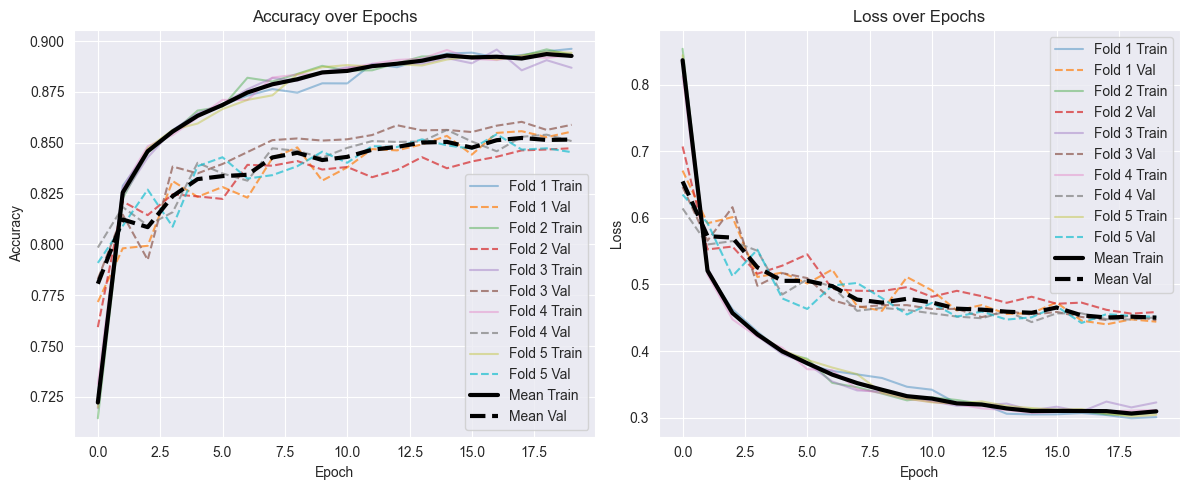

In [10]:
# ===================== SAVE ENCODER & FOLD MODELS =====================
import pickle
from tensorflow.keras.models import load_model
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

# 1) Save label encoder (class mapping)
with open("label_encoder.pkl", "wb") as f:
    pickle.dump(le, f)
print("[INFO] Saved label encoder → label_encoder.pkl")

# 2) (Optional) Re-save last fold's model with a friendly name
#    We already saved per fold as best_fold_{k}.keras in the loop.
#    If you want a single 'export' model, copy the last fold's file:
import shutil, os
last_fold_path = f"best_fold_{N_SPLITS}.keras"
if os.path.exists(last_fold_path):
    shutil.copy(last_fold_path, "mobilenet_trash.keras")
    print(f"[INFO] Exported final model copy → mobilenet_trash.keras (from {last_fold_path})")
else:
    print("[WARN] Not exporting mobilenet_trash.keras because best_fold_N file was not found.")



# ===================== PLOTS: PER-FOLD AND AVERAGE LEARNING CURVES =====================
# fold_histories is a list of history.history dicts (one per fold)
def plot_cv_curves(fold_histories, metric="accuracy", val_metric="val_accuracy", title="Accuracy over Epochs"):
    plt.figure(figsize=(12,5))

    # Left: accuracy
    plt.subplot(1,2,1)
    max_len = 0
    for i, h in enumerate(fold_histories, 1):
        acc = h.get(metric, [])
        val_acc = h.get(val_metric, [])
        if len(acc) == 0:
            continue
        max_len = max(max_len, len(acc))
        plt.plot(acc, alpha=0.4, label=f"Fold {i} Train")
        plt.plot(val_acc, alpha=0.7, linestyle="--", label=f"Fold {i} Val")
    # Average curve (pad shorter histories with nan to compute mean over existing points)
    if max_len > 0:
        acc_stack = []
        val_acc_stack = []
        for h in fold_histories:
            a = np.array(h.get(metric, []), dtype=float)
            va = np.array(h.get(val_metric, []), dtype=float)
            if a.size == 0:
                continue
            # pad to max_len with nan
            a = np.pad(a, (0, max_len - a.size), constant_values=np.nan)
            va = np.pad(va, (0, max_len - va.size), constant_values=np.nan)
            acc_stack.append(a)
            val_acc_stack.append(va)
        if len(acc_stack) > 0:
            mean_acc = np.nanmean(np.vstack(acc_stack), axis=0)
            mean_val_acc = np.nanmean(np.vstack(val_acc_stack), axis=0)
            plt.plot(mean_acc, linewidth=3, label="Mean Train", color="black")
            plt.plot(mean_val_acc, linewidth=3, linestyle="--", label="Mean Val", color="black")
    plt.title(title)
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()

    # Right: loss
    plt.subplot(1,2,2)
    metric_l, val_metric_l = "loss", "val_loss"
    max_len = 0
    for i, h in enumerate(fold_histories, 1):
        l = h.get(metric_l, [])
        vl = h.get(val_metric_l, [])
        if len(l) == 0:
            continue
        max_len = max(max_len, len(l))
        plt.plot(l, alpha=0.4, label=f"Fold {i} Train")
        plt.plot(vl, alpha=0.7, linestyle="--", label=f"Fold {i} Val")
    if max_len > 0:
        l_stack, vl_stack = [], []
        for h in fold_histories:
            l = np.array(h.get(metric_l, []), dtype=float)
            vl = np.array(h.get(val_metric_l, []), dtype=float)
            if l.size == 0:
                continue
            l = np.pad(l, (0, max_len - l.size), constant_values=np.nan)
            vl = np.pad(vl, (0, max_len - vl.size), constant_values=np.nan)
            l_stack.append(l); vl_stack.append(vl)
        if len(l_stack) > 0:
            mean_l = np.nanmean(np.vstack(l_stack), axis=0)
            mean_vl = np.nanmean(np.vstack(vl_stack), axis=0)
            plt.plot(mean_l, linewidth=3, label="Mean Train", color="black")
            plt.plot(mean_vl, linewidth=3, linestyle="--", label="Mean Val", color="black")
    plt.title("Loss over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_cv_curves(fold_histories)

#### Overall confusion matrix & report


========== OVERALL CLASSIFICATION REPORT (All folds) ==========
              precision    recall  f1-score   support

     battery     0.9015    0.8698    0.8854      1989
  biological     0.9444    0.9316    0.9380      1989
 brown-glass     0.8638    0.7908    0.8257      1989
   cardboard     0.8980    0.8678    0.8826      1989
     clothes     0.9644    0.9542    0.9593      1989
 green-glass     0.9214    0.8482    0.8832      1989
       metal     0.8074    0.7355    0.7698      1989
       paper     0.8663    0.8829    0.8745      1989
     plastic     0.6981    0.7104    0.7042      1989
       shoes     0.9303    0.9467    0.9385      1989
       trash     0.8315    0.9105    0.8692      1989
 white-glass     0.6756    0.8084    0.7361      1989

    accuracy                         0.8547     23868
   macro avg     0.8586    0.8547    0.8555     23868
weighted avg     0.8586    0.8547    0.8555     23868



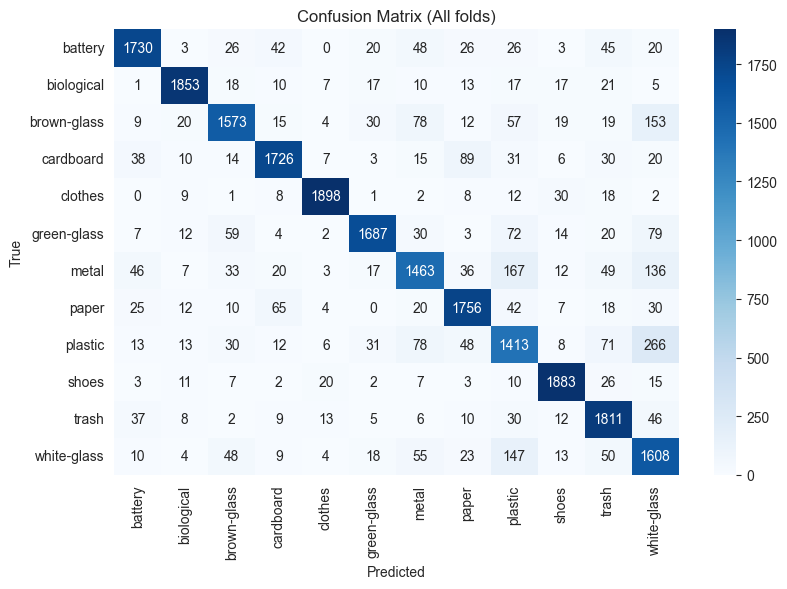

In [17]:
# ===================== OVERALL CONFUSION MATRIX & REPORT (ACROSS ALL FOLDS) =====================
# You already collected these during CV:
#   - all_true : true class indices over all folds
#   - all_pred : predicted class indices over all folds
print("\n========== OVERALL CLASSIFICATION REPORT (All folds) ==========")
print(classification_report(all_true, all_pred, target_names=classes, digits=4, zero_division=0))

cm = confusion_matrix(all_true, all_pred, labels=list(range(num_classes)))
plt.figure(figsize=(max(8, num_classes*0.7), max(6, num_classes*0.5)))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=classes, yticklabels=classes)
plt.title("Confusion Matrix (All folds)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()

## Ensemble Model (Soft Voting)

In [21]:
# Define test dataset path
TEST_DATASET_PATH = r"F:\UOJE\Semester 7\Digital Image Processing\Project\data\final"

# Load test dataset paths and labels
X_test, y_test = [], []
for folder in os.listdir(TEST_DATASET_PATH):
    folder_path = os.path.join(TEST_DATASET_PATH, folder)
    if os.path.isdir(folder_path):
        for file in os.listdir(folder_path):
            if file.lower().endswith(VALID_EXTS):
                X_test.append(os.path.join(folder_path, file))
                y_test.append(folder)

# Encode test labels
y_test_idx = le.transform(y_test)  # Use the saved label encoder
y_test = to_categorical(y_test_idx, num_classes=num_classes)

# Convert to numpy arrays
X_test = np.array(X_test)
y_test = np.array(y_test)

# Create the test dataset
ds_test = make_ds(X_test, y_test, training=False, batch_size=BATCH_SIZE)

In [20]:
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input
import numpy as np

class EnsembleModel(Model):
    def __init__(self, model_paths):
        super(EnsembleModel, self).__init__()
        self.models = [load_model(path) for path in model_paths]

    def call(self, inputs):
        # Collect predictions from all models
        all_probs = [model(inputs, training=False) for model in self.models]
        # Average the probabilities (soft voting)
        avg_probs = tf.reduce_mean(all_probs, axis=0)
        return avg_probs

# Paths to the saved models
model_paths = [f"best_fold_{i}.keras" for i in range(1, N_SPLITS + 1)]

# Create the ensemble model
ensemble_model = EnsembleModel(model_paths)
# Build the model by calling it on dummy input data
dummy_input = tf.random.normal([1, IMG_SIZE, IMG_SIZE, 3])  # Adjust shape as needed
_ = ensemble_model(dummy_input)
# Save the ensemble model
ensemble_model.save("final_ensemble_model.keras")


In [22]:
import numpy as np
from tensorflow.keras.models import load_model

# Paths to the saved models
model_paths = [f"best_fold_{i}.keras" for i in range(1, N_SPLITS + 1)]

# Load all models
models = [load_model(path) for path in model_paths]

# Create a dataset for testing (replace `X_test` and `y_test` with your test data)
ds_test = make_ds(X_test, y_test, training=False, batch_size=BATCH_SIZE)

# Collect predictions from all models
all_probs = []
for model in models:
    probs = model.predict(ds_test, verbose=0)  # Predict probabilities
    all_probs.append(probs)

# Average the probabilities (soft voting)
avg_probs = np.mean(all_probs, axis=0)

# Final predictions (class with the highest probability)
final_preds = np.argmax(avg_probs, axis=1)

# Evaluate the ensemble model
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_test.argmax(axis=1), final_preds, target_names=classes))
cm = confusion_matrix(y_test.argmax(axis=1), final_preds)
print("Confusion Matrix:\n", cm)

              precision    recall  f1-score   support

     battery       0.95      0.93      0.94      1989
  biological       0.99      0.98      0.98      1989
 brown-glass       0.93      0.86      0.90      1989
   cardboard       0.95      0.92      0.94      1989
     clothes       0.99      0.98      0.99      1989
 green-glass       0.97      0.91      0.94      1989
       metal       0.89      0.81      0.85      1989
       paper       0.92      0.94      0.93      1989
     plastic       0.80      0.82      0.81      1989
       shoes       0.97      0.99      0.98      1989
       trash       0.90      0.96      0.93      1989
 white-glass       0.77      0.89      0.83      1989

    accuracy                           0.92     23868
   macro avg       0.92      0.92      0.92     23868
weighted avg       0.92      0.92      0.92     23868

Confusion Matrix:
 [[1841    1   13   21    0    9   28   16   14    2   28   16]
 [   0 1943    6    3    1    2    3    4    5    5

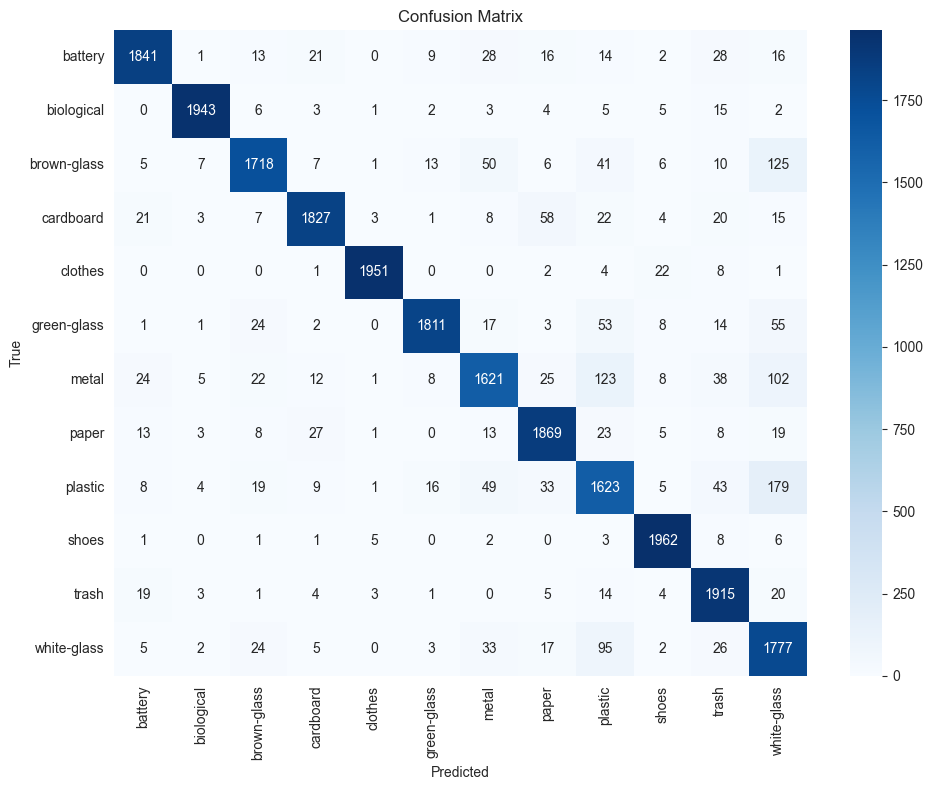

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt

# Generate the confusion matrix
cm = confusion_matrix(y_test.argmax(axis=1), final_preds)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()